In [1]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install torchsummary
from torchsummary import summary
from transformers import ViTModel, ViTConfig, ViTForImageClassification

# set the path to the directory containing the npy files
data_dir = '/kaggle/input/ndvipure'

# set the path to save the trained model
model_path = '/kaggle/working/eumodel'

if not os.path.exists(model_path):
    os.makedirs(model_path)
# load the X and y data for each class
X = []
y = []
for i in range(10):
    X_i = np.load(f'{data_dir}/X{i}.npy')
    y_i = np.load(f'{data_dir}/y{i}.npy')
    X.append(X_i)
    y.append(y_i)

# concatenate the X and y data for all classes
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install einops
import einops
print(X.shape)


X = einops.rearrange(X, 'b h w c -> b c h w')
              
print(X.shape)

print(X[0].shape)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.6 MB/s eta 0:00:00
(27000, 64, 64, 1)
(27000, 1, 64, 64)
(1, 64, 64)


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit


# split the data into training and testing sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# split the data
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [4]:
del X
del y

In [5]:

# define a custom dataset class for the EuroSAT multispectral data
class EuroSATDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# create data loaders for the training and testing sets
train_dataset = EuroSATDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = EuroSATDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# set the device to use for training and testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [7]:
# Define the ResNet-152 model
model = models.resnet152(pretrained=True)
num_classes = 10
model.fc = nn.Linear(2048, num_classes)

# Modify the first convolution layer to accept 5-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model and loss function to the device
model.to(device)
criterion.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 96.5MB/s] 


CrossEntropyLoss()

In [8]:
import torchsummary

# Print the model summary
torchsummary.summary(model.to(device), input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [9]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)
    
    model.train()
    running_loss=0
    correct=0
    total=0

    for images, labels in tqdm(train_loader):
        
        images = images.float().cuda()
        labels = labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))
        
        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)
        
        
       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    #Replaces pow(2.0) with abs() for L1 regularization
    
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm
    
        
        running_loss += loss.item()
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
  
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    

In [10]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            labels = labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)
            
            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()
            
            
           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    

In [11]:
from tqdm import tqdm

In [12]:
import time
epochs = 30

# Start the timer

start_time = time.time()
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))


Epoch : 1


100%|██████████| 675/675 [01:18<00:00,  8.60it/s]


Train Loss: 1.019 | Accuracy: 64.361


100%|██████████| 169/169 [00:04<00:00, 37.20it/s]


Test Loss: 2.938 | Accuracy: 41.963
Epoch : 2


100%|██████████| 675/675 [01:17<00:00,  8.71it/s]


Train Loss: 0.693 | Accuracy: 75.963


100%|██████████| 169/169 [00:04<00:00, 37.58it/s]


Test Loss: 1.288 | Accuracy: 66.037
Epoch : 3


100%|██████████| 675/675 [01:17<00:00,  8.68it/s]


Train Loss: 0.535 | Accuracy: 81.444


100%|██████████| 169/169 [00:04<00:00, 37.57it/s]


Test Loss: 9.715 | Accuracy: 33.426
Epoch : 4


100%|██████████| 675/675 [01:17<00:00,  8.67it/s]


Train Loss: 0.516 | Accuracy: 82.509


100%|██████████| 169/169 [00:04<00:00, 37.43it/s]


Test Loss: 1.012 | Accuracy: 67.241
Epoch : 5


100%|██████████| 675/675 [01:17<00:00,  8.70it/s]


Train Loss: 0.429 | Accuracy: 85.213


100%|██████████| 169/169 [00:04<00:00, 37.30it/s]


Test Loss: 2.641 | Accuracy: 57.222
Epoch : 6


100%|██████████| 675/675 [01:17<00:00,  8.66it/s]


Train Loss: 0.365 | Accuracy: 87.458


100%|██████████| 169/169 [00:04<00:00, 37.53it/s]


Test Loss: 1.607 | Accuracy: 56.519
Epoch : 7


100%|██████████| 675/675 [01:17<00:00,  8.66it/s]


Train Loss: 0.343 | Accuracy: 88.292


100%|██████████| 169/169 [00:04<00:00, 37.58it/s]


Test Loss: 5.774 | Accuracy: 47.222
Epoch : 8


100%|██████████| 675/675 [01:17<00:00,  8.71it/s]


Train Loss: 0.303 | Accuracy: 89.704


100%|██████████| 169/169 [00:04<00:00, 37.25it/s]


Test Loss: 1.117 | Accuracy: 70.685
Epoch : 9


100%|██████████| 675/675 [01:17<00:00,  8.67it/s]


Train Loss: 0.283 | Accuracy: 90.296


100%|██████████| 169/169 [00:04<00:00, 37.35it/s]


Test Loss: 2.946 | Accuracy: 62.741
Epoch : 10


100%|██████████| 675/675 [01:17<00:00,  8.68it/s]


Train Loss: 0.233 | Accuracy: 91.718


100%|██████████| 169/169 [00:04<00:00, 37.61it/s]


Test Loss: 3.903 | Accuracy: 59.648
Epoch : 11


100%|██████████| 675/675 [01:17<00:00,  8.70it/s]


Train Loss: 0.208 | Accuracy: 92.699


100%|██████████| 169/169 [00:04<00:00, 37.73it/s]


Test Loss: 0.527 | Accuracy: 83.833
Epoch : 12


100%|██████████| 675/675 [01:17<00:00,  8.66it/s]


Train Loss: 0.176 | Accuracy: 93.954


100%|██████████| 169/169 [00:04<00:00, 37.25it/s]


Test Loss: 6.248 | Accuracy: 60.852
Epoch : 13


100%|██████████| 675/675 [01:17<00:00,  8.70it/s]


Train Loss: 0.174 | Accuracy: 94.111


100%|██████████| 169/169 [00:04<00:00, 37.45it/s]


Test Loss: 5.711 | Accuracy: 53.741
Epoch : 14


100%|██████████| 675/675 [01:17<00:00,  8.67it/s]


Train Loss: 0.145 | Accuracy: 94.940


100%|██████████| 169/169 [00:04<00:00, 37.35it/s]


Test Loss: 0.483 | Accuracy: 85.667
Epoch : 15


100%|██████████| 675/675 [01:17<00:00,  8.68it/s]


Train Loss: 0.127 | Accuracy: 95.532


100%|██████████| 169/169 [00:04<00:00, 37.24it/s]


Test Loss: 1.530 | Accuracy: 66.241
Epoch : 16


100%|██████████| 675/675 [01:17<00:00,  8.76it/s]


Train Loss: 0.107 | Accuracy: 96.241


100%|██████████| 169/169 [00:04<00:00, 37.67it/s]


Test Loss: 0.623 | Accuracy: 84.537
Epoch : 17


100%|██████████| 675/675 [01:17<00:00,  8.71it/s]


Train Loss: 0.107 | Accuracy: 96.347


100%|██████████| 169/169 [00:04<00:00, 37.39it/s]


Test Loss: 2.324 | Accuracy: 64.870
Epoch : 18


100%|██████████| 675/675 [01:17<00:00,  8.74it/s]


Train Loss: 0.092 | Accuracy: 96.769


100%|██████████| 169/169 [00:04<00:00, 37.58it/s]


Test Loss: 1.839 | Accuracy: 65.537
Epoch : 19


100%|██████████| 675/675 [01:16<00:00,  8.77it/s]


Train Loss: 0.093 | Accuracy: 96.704


100%|██████████| 169/169 [00:04<00:00, 37.60it/s]


Test Loss: 9.864 | Accuracy: 52.667
Epoch : 20


100%|██████████| 675/675 [01:17<00:00,  8.76it/s]


Train Loss: 0.108 | Accuracy: 96.398


100%|██████████| 169/169 [00:04<00:00, 37.71it/s]


Test Loss: 0.509 | Accuracy: 87.593
Epoch : 21


100%|██████████| 675/675 [01:17<00:00,  8.76it/s]


Train Loss: 0.082 | Accuracy: 97.398


100%|██████████| 169/169 [00:04<00:00, 37.82it/s]


Test Loss: 5.029 | Accuracy: 56.130
Epoch : 22


100%|██████████| 675/675 [01:16<00:00,  8.77it/s]


Train Loss: 0.068 | Accuracy: 97.699


100%|██████████| 169/169 [00:04<00:00, 37.76it/s]


Test Loss: 3.098 | Accuracy: 57.833
Epoch : 23


100%|██████████| 675/675 [01:17<00:00,  8.76it/s]


Train Loss: 0.060 | Accuracy: 97.921


100%|██████████| 169/169 [00:04<00:00, 37.57it/s]


Test Loss: 3.213 | Accuracy: 64.130
Epoch : 24


100%|██████████| 675/675 [01:17<00:00,  8.75it/s]


Train Loss: 0.067 | Accuracy: 97.713


100%|██████████| 169/169 [00:04<00:00, 37.70it/s]


Test Loss: 1.203 | Accuracy: 77.056
Epoch : 25


100%|██████████| 675/675 [01:16<00:00,  8.77it/s]


Train Loss: 0.065 | Accuracy: 97.713


100%|██████████| 169/169 [00:04<00:00, 37.65it/s]


Test Loss: 0.616 | Accuracy: 85.704
Epoch : 26


100%|██████████| 675/675 [01:17<00:00,  8.72it/s]


Train Loss: 0.066 | Accuracy: 97.819


100%|██████████| 169/169 [00:04<00:00, 37.62it/s]


Test Loss: 1.482 | Accuracy: 71.704
Epoch : 27


100%|██████████| 675/675 [01:17<00:00,  8.75it/s]


Train Loss: 0.067 | Accuracy: 97.704


100%|██████████| 169/169 [00:04<00:00, 37.73it/s]


Test Loss: 0.947 | Accuracy: 79.426
Epoch : 28


100%|██████████| 675/675 [01:16<00:00,  8.77it/s]


Train Loss: 0.054 | Accuracy: 98.125


100%|██████████| 169/169 [00:04<00:00, 37.71it/s]


Test Loss: 0.754 | Accuracy: 83.315
Epoch : 29


100%|██████████| 675/675 [01:17<00:00,  8.73it/s]


Train Loss: 0.053 | Accuracy: 98.306


100%|██████████| 169/169 [00:04<00:00, 37.76it/s]


Test Loss: 3.060 | Accuracy: 64.148
Epoch : 30


100%|██████████| 675/675 [01:17<00:00,  8.75it/s]


Train Loss: 0.052 | Accuracy: 98.190


100%|██████████| 169/169 [00:04<00:00, 37.56it/s]

Test Loss: 0.648 | Accuracy: 86.019
Training time: 2459.47 seconds


In [13]:
import matplotlib.pyplot as plt


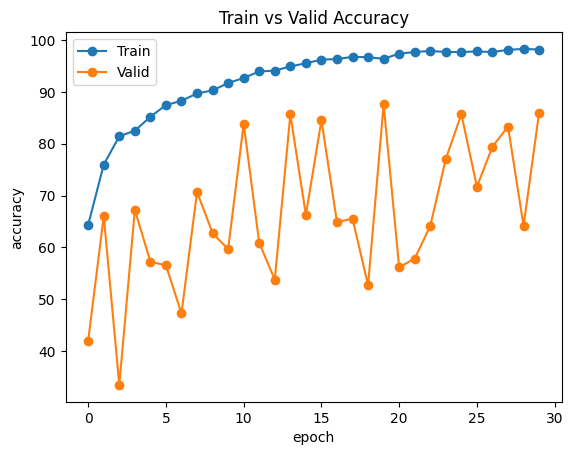

In [14]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

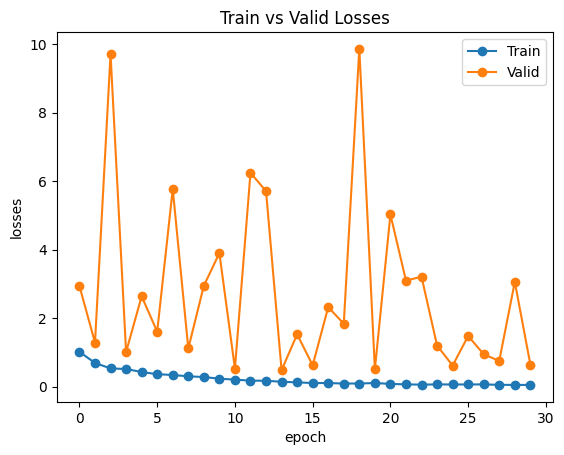

In [15]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [16]:
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score

# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for (X_val, y_val) in tqdm(test_loader):
        X_val = X_val.float().cuda()
        y_val = y_val.float().cuda()
        #X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)
        
        output = model(X_val)
        #print(output.shape)
        
        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)
    
    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)

100%|██████████| 169/169 [00:04<00:00, 38.69it/s]

Precision:  0.8582894655588167
Recall:  0.8574833333333333
Confusion matrix:
 [[553   0   9   1   1  15  20   0   1   0]
 [  4 566  11   4   1   5   4   5   0   0]
 [ 42  44 432  11   6  17  43   1   3   1]
 [ 15  15  17 401  13  21   6   1  11   0]
 [  0   1   2  18 454   5   2  15   3   0]
 [ 21   5  10   5   0 349  10   0   0   0]
 [ 76  10  31  14   3  77 288   0   1   0]
 [  0  35   1   7  35   0   3 519   0   0]
 [  2   0   1   7   3   1   0   0 484   2]
 [  0   0   0   0   0   0   0   0   1 599]]
Report:
               precision    recall  f1-score   support

         0.0       0.78      0.92      0.84       600
         1.0       0.84      0.94      0.89       600
         2.0       0.84      0.72      0.78       600
         3.0       0.86      0.80      0.83       500
         4.0       0.88      0.91      0.89       500
         5.0       0.71      0.87      0.78       400
         6.0       0.77      0.58      0.66       500
         7.0       0.96      0.86      0.91      